In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler
from matplotlib import pyplot as plt

### Define Data Path and Load period

In [2]:
path = '../data-sets/KDD-Cup/data/'
period_path = '../data-sets/KDD-Cup/period/period.csv'
files_name = [i for i in os.listdir(path) if 'Anomaly' in i] #remove irrelevant files
files_name.sort(key = lambda x : x.split('_')[0]) #sort by id

In [3]:
period = pd.read_csv(period_path) #load period file calculated by fourier transform
period.head()

,File_name,Period
0,001_UCR_Anomaly_35000.txt,210
1,002_UCR_Anomaly_35000.txt,208
2,003_UCR_Anomaly_35000.txt,209
3,004_UCR_Anomaly_2500.txt,80
4,005_UCR_Anomaly_4000.txt,24


### Load data

In [4]:
name = files_name[176]
print("The example data used is :",name)
split_index  = int(name.split('.')[0].split('_')[3]) #get split index
data = pd.read_csv(path+name,header=None)
if data.shape == (1,1):
    tmp = [i for i in data[0][0].split(' ') if i!= '']
    data = pd.DataFrame({0:tmp}).astype('float')
train,test = data[0:split_index],data[split_index::] #split
test = test.reset_index().drop('index',axis=1)

The example data used is : 177_UCR_Anomaly_3200.txt


### Normalize

In [5]:
training_mean = train.mean()  #record mean
training_std = train.std() #record std
normalized_train = (train - training_mean) / training_std
normalized_test = (test - training_mean) / training_std

### Create Sequence Data

In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = int(period[period['File_name'] == name]['Period'])

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(
  normalized_train[[0]],
  normalized_train[0],
  TIME_STEPS
)

X_test, y_test = create_dataset(
  normalized_test [[0]],
  normalized_test [0],
  TIME_STEPS
)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(3174, 26, 1) (3174,)
(6802, 26, 1) (6802,)


### Build Model

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.summary()

### Traning

In [30]:
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 10
    end_lr = 0.0001
    lrate = initial_lrate * np.power(drop,  
        np.floor((1+epoch)/epochs_drop))
    if lrate > end_lr:
        return lrate
    else:
        return end_lr
    

epochs = 100
batch_size = 32
lr_scheduler = LearningRateScheduler(step_decay)
optimizer = keras.optimizers.Adam(0.01)

model.compile(optimizer=optimizer, loss="mae")

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    shuffle=False
)

Train on 2539 samples, validate on 635 samples
Epoch 1/100
2539/2539 [==============================] - 6s 2ms/sample - loss: 0.2499 - val_loss: 0.13
Epoch 2/100
2539/2539 [==============================] - 2s 864us/sample - loss: 0.1574 - val_loss: 0.10
Epoch 3/100
2539/2539 [==============================] - 2s 824us/sample - loss: 0.1362 - val_loss: 0.09
Epoch 4/100
2539/2539 [==============================] - 2s 836us/sample - loss: 0.1297 - val_loss: 0.07
Epoch 5/100
2539/2539 [==============================] - 2s 808us/sample - loss: 0.1227 - val_loss: 0.07
Epoch 6/100
2539/2539 [==============================] - 2s 818us/sample - loss: 0.1081 - val_loss: 0.05
Epoch 7/100
2539/2539 [==============================] - 2s 834us/sample - loss: 0.1089 - val_loss: 0.06
Epoch 8/100
2539/2539 [==============================] - 2s 825us/sample - loss: 0.1036 - val_loss: 0.06
Epoch 9/100
2539/2539 [==============================] - 2s 839us/sample - loss: 0.1020 - val_loss: 0.08
Epoch 10/1

### Plot Training History

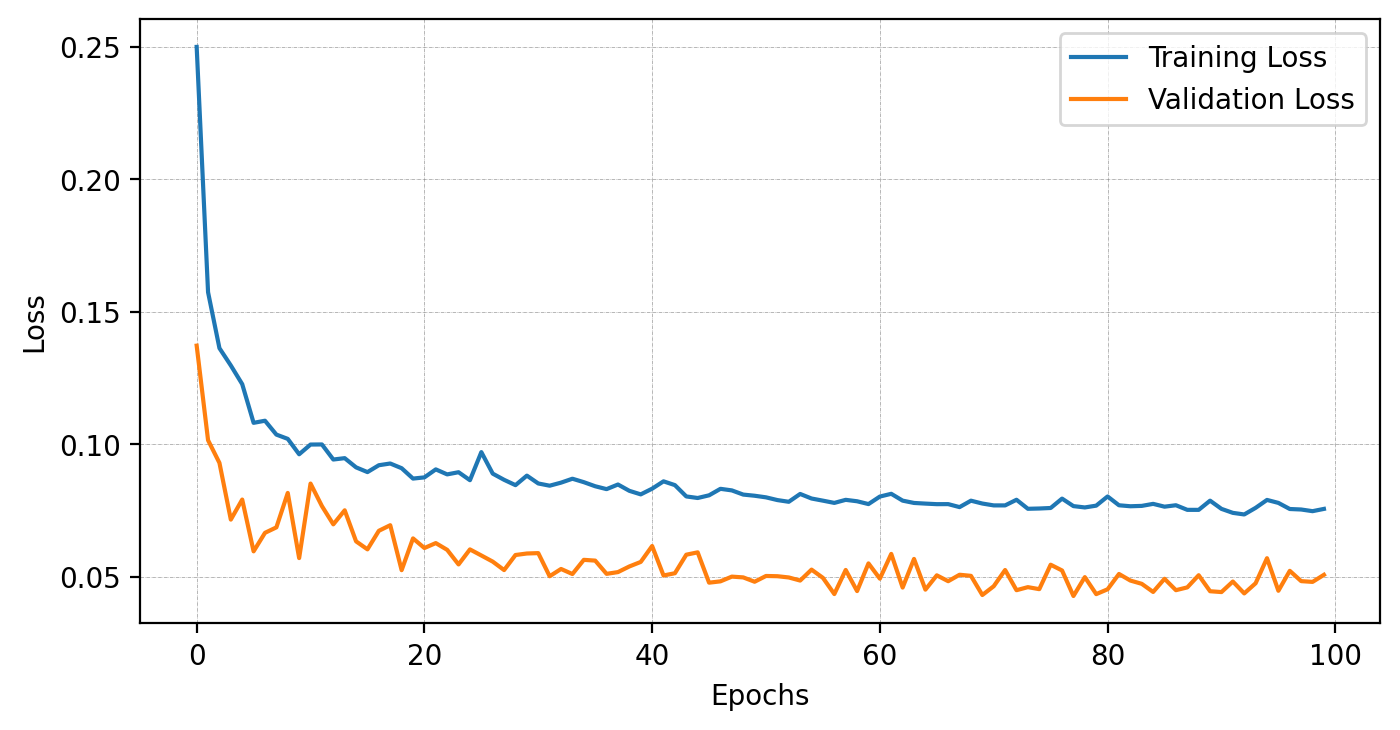

In [31]:
fig = plt.figure(figsize=[8,4],dpi=200)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Make Prediction on Test data

In [38]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test_mae_loss_adjusted = np.append(np.zeros(TIME_STEPS),test_mae_loss)

Text(0.5, 1.0, 'MAE Loss on test data')

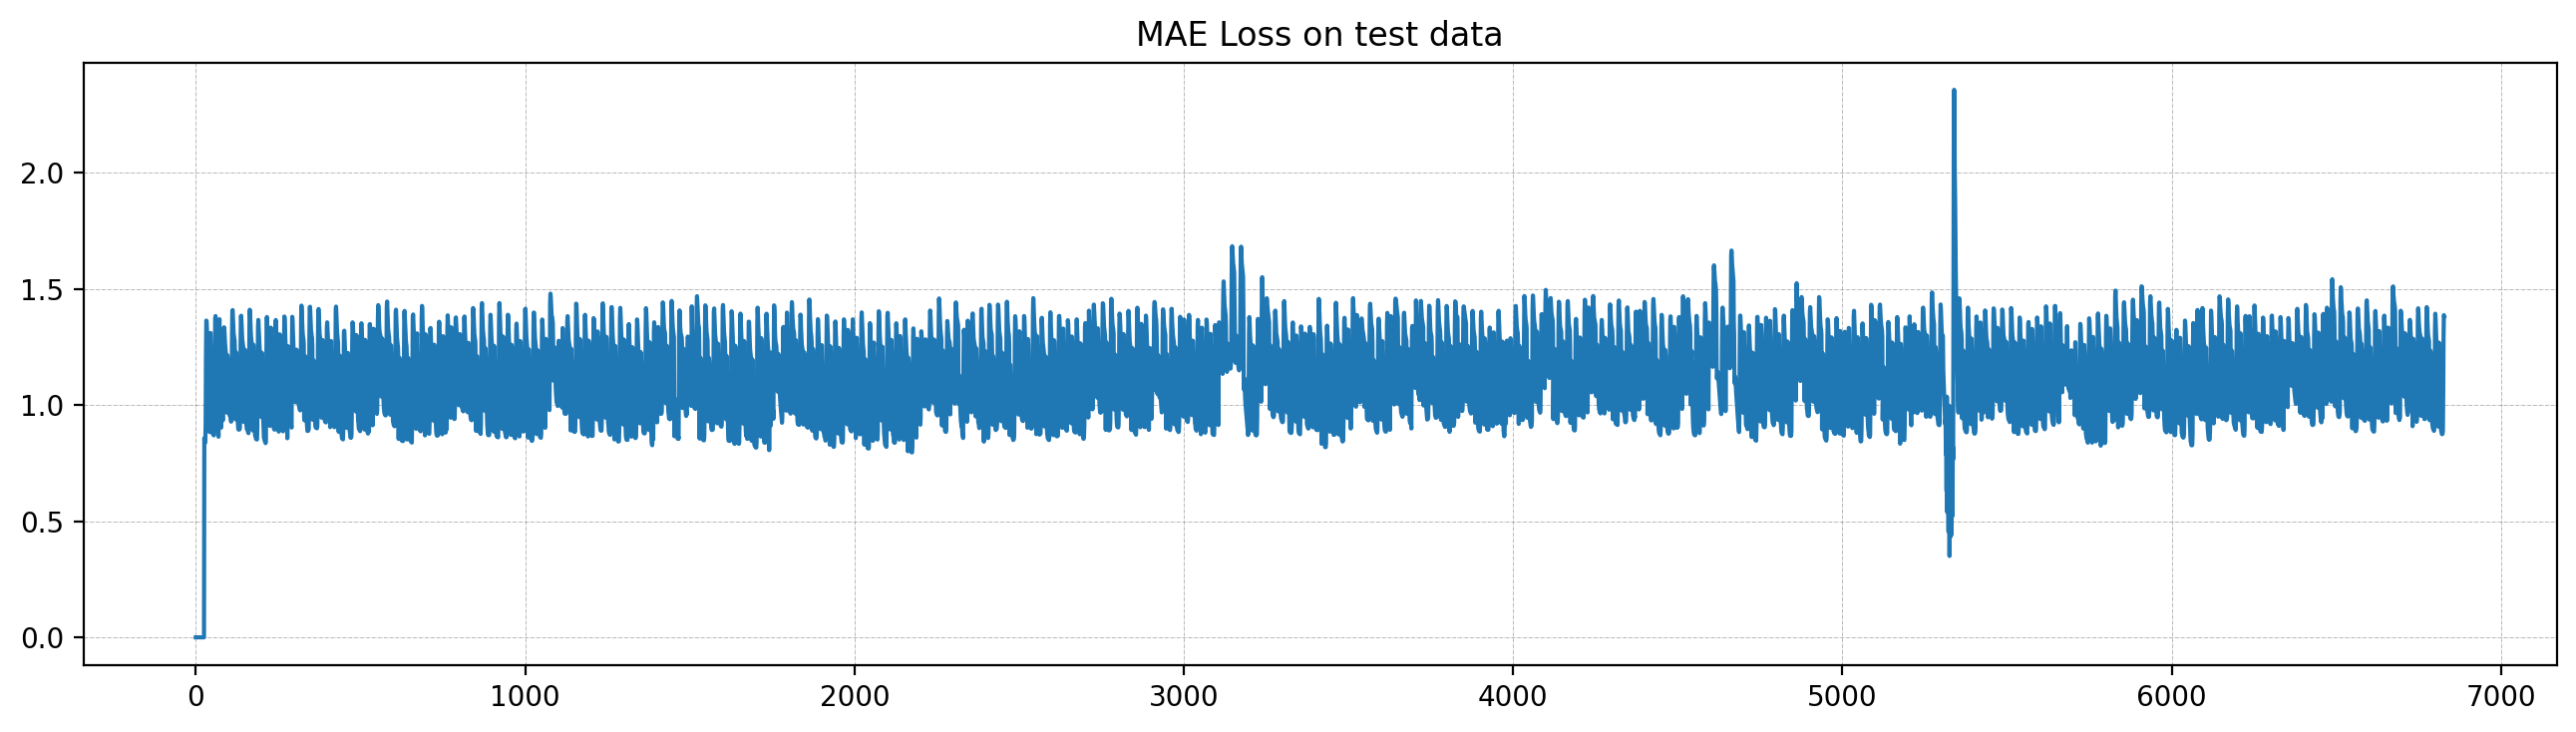

In [39]:
fig = plt.figure(figsize=[16,4],dpi=200)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.plot(test_mae_loss_adjusted)
plt.title('MAE Loss on test data')

### Plot the suspicous region as detected anomaly

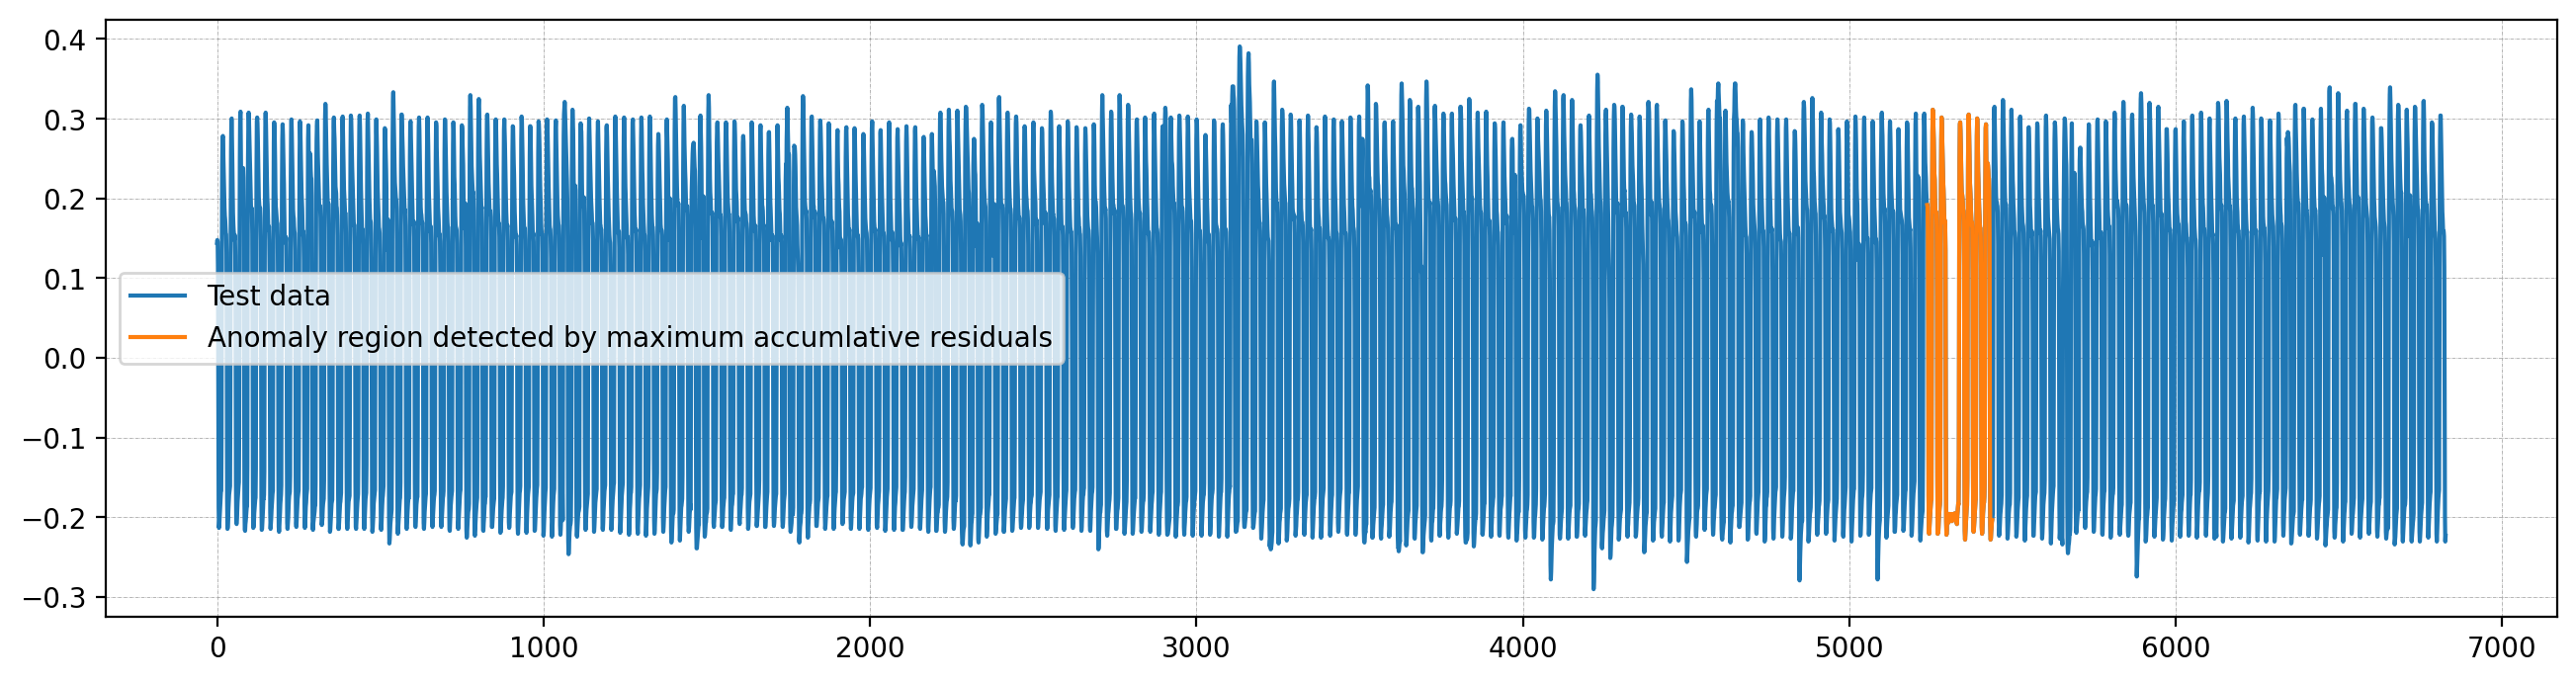

In [45]:
center = np.argmax(test_mae_loss_adjusted)

fig = plt.figure(figsize=[16,4],dpi=200)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.plot(test,label='Test data')
plt.plot(range(center-100,center+100),test[center-100:center+100],label='Anomaly region detected by maximum accumlative residuals')
plt.legend()